In [1]:
import gym
from gym import wrappers
from gym.spaces.utils import flatdim

import torch as pt
from torch import nn
from torch.functional import F
from torch.utils.tensorboard import SummaryWriter
import cv2

import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm

import io
from copy import deepcopy
import base64
from IPython.display import HTML

# Comment out for debugging
import warnings
warnings.filterwarnings('ignore')

/home/luke/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Algorithm outline
def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    slope = (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)

class ReplayMemory():
    def __init__(self, size, env):
        self.size = size
        self.counter = 0

        obs_shape = env.observation_space.shape

        self.obs = np.zeros((size, *obs_shape), dtype=np.float32)
        self.actions = np.zeros((size, 1), env.action_space.dtype)
        self.rewards = np.zeros((size, 1), dtype=np.float32)
        self.obs_n = np.zeros((size, *obs_shape), dtype=np.float32)
        self.done = np.zeros((size, 1), dtype=np.float32)
    
    def store_transition(self, obs, action, obs_n, r, done):
        indx = self.counter % self.size

        self.obs[indx] = np.array(obs).copy()
        self.actions[indx] = np.array(action).copy()
        self.rewards[indx] = np.array(r).copy()
        self.obs_n[indx] = np.array(obs_n).copy()
        self.done[indx] = np.array(done).copy()

        self.counter += 1
    
    def sample_batch(self, batch_size):
        batch = np.random.randint(0, self.size, size=batch_size)

        obs = pt.as_tensor(self.obs[batch])
        actions = pt.as_tensor(self.actions[batch])
        rewards = pt.as_tensor(self.rewards[batch])
        obs_n = pt.as_tensor(self.obs_n[batch])
        terminal = pt.as_tensor(self.done[batch])

        return obs, actions, obs_n, rewards, terminal


class SimpleQNet(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(np.array(env.observation_space.shape).prod(), 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, env.action_space.n)
        )
    
    def forward(self, x):
        return self.network(x)

class ConvQNet(nn.Module):
    def __init__(self, env):
        super(ConvQNet, self).__init__()
        self.obs_shape = env.observation_space.low.shape
        self.act_shape = flatdim(env.action_space)
        self.replay_memory = []

        self.conv1 = nn.Conv2d(self.obs_shape[0], 16, 8, stride=4)
        self.conv2 = nn.Conv2d(16, 32, 4, stride=2)
        self.fc1 = nn.Linear(2592, 256) # mathemagic
        self.out = nn.Linear(256, self.act_shape)

        self.optimizer = pt.optim.RMSprop(self.parameters(), lr=1e-4)
        self.loss = nn.MSELoss()
    
    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        return self.out(x)

DEFAULT_HPARAMS = {
    "training_steps": 250_000,
    "batch_size": 256,
    "update_freq": 1000,
    "learning_rate": 1e-4,
    "buffer_size": 50_000,
    "gamma": 0.99,
    "train_freq": 4
}

def train_model(env, Q: SimpleQNet, hparams):
    # Pseudocode from DQN Paper
    device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
    writer = SummaryWriter("acrobot")

    # Hyperparams
    batch_size = hparams["batch_size"]
    update_freq = hparams["update_freq"]
    gamma = hparams["gamma"]
    buffer_size = hparams["buffer_size"]
    lr = hparams["learning_rate"]
    training_steps = hparams["training_steps"]


    # Intialize optimizer
    optimizer = pt.optim.Adam(Q.parameters(), lr=lr)

    # Initialize Replay Memory to capacity N
    memory = ReplayMemory(buffer_size, env)

    # Initialize action-value Function Q with random weights
    T = deepcopy(Q)

    obs, _ = env.reset()
    ep_return = 0
    ep_length = 0
    for global_step in tqdm(range(training_steps)):

        # Select action random action with prob epsilon, otherwise argmax_a Q(obs, a)
        epsilon = linear_schedule(1.0, 0.05, 0.1 * training_steps ,global_step)
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            q_vals = Q(pt.Tensor(obs))
            action = pt.argmax(q_vals).cpu().numpy()

        obs_n, r, done, _, info = env.step(action)

        # Record statistics seems to be broken for some envs
        ep_return += r
        ep_length += 1

        if "episode" in info.keys():
            writer.add_scalar("charts/episodic_return", ep_return, global_step)
            writer.add_scalar("charts/episodic_length", ep_length, global_step)
            writer.add_scalar("charts/epsilon", epsilon, global_step)

        memory.store_transition(obs, action, obs_n, r, done)

        # handle terminal observations
        obs = obs_n
        if done:
            obs, _ = env.reset()
            ep_return = 0
            ep_length = 0

        if (memory.counter > memory.size and global_step % hparams["train_freq"] == 0):

            # Update network weights on batch
            states, actions, states_, rewards, dones = memory.sample_batch(batch_size)

            # Target values
            with pt.no_grad():
                q_next, _ = T.forward(states_).max(dim=1)
                q_next = q_next.reshape(-1, 1)
                q_target = rewards + gamma*(1-dones)*q_next

            # Predicted values
            q_pred = Q.forward(states)
            q_pred = pt.gather(q_pred, dim=1, index=actions)

            loss = F.smooth_l1_loss(q_pred, q_target)
        
            # Optimize
            optimizer.zero_grad()
            loss.backward()

            # Stable baselines:  https://github.com/DLR-RM/stable-baselines3/blob/4fb8aec215fd2dd5d668aae8285937c268baca97/stable_baselines3/dqn/dqn.py#L216
            # nn.utils.clip_grad_norm_(Q.parameters(), 10)             

            optimizer.step()

            if global_step % 200 == 0:
                grads = [pt.flatten(params.grad.detach()) for params in Q.parameters()]
                grads = pt.cat(grads).view(-1,1)
                writer.add_histogram("charts/action_dist", actions, global_step)
                writer.add_scalar("losses/grads", np.linalg.norm(grads.numpy()), global_step)
                writer.add_scalar("losses/td_loss", loss.detach().numpy(), global_step)
                writer.add_scalar("losses/value_fn", q_pred.mean().item(), global_step)
                writer.add_scalar("losses/q_vals [max]", q_pred.max().item(), global_step)

            if global_step % update_freq == 0:
                T.load_state_dict(Q.state_dict())
    
    env.close()
    writer.close()
    return Q
    
def generate_video(net, env, steps):

    obs, _ = env.reset()
    for i in range(steps):
        q_vals = net(pt.Tensor(obs))
        action = pt.argmax(q_vals).cpu().numpy()

        obs, _, done, _, info = env.step(action)

        if done:
            break
    
    env.close()
    return



In [8]:
env = gym.make("Acrobot-v1")
env = gym.wrappers.RecordEpisodeStatistics(env)
q = SimpleQNet(env)
q = train_model(env, q, DEFAULT_HPARAMS)

env = gym.make("Acrobot-v1", render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, "./acrobot")
generate_video(q, env, 2000)

ValueError: too many values to unpack (expected 2)

In [40]:
env = gym.make("CartPole-v1")
env = gym.wrappers.RecordEpisodeStatistics(env)
q = SimpleQNet(env)
q = train_model(env, q, DEFAULT_HPARAMS)

env = gym.make("CartPole-v1", render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, "./cartpole")
generate_video(q, env, 2000)

Moviepy - Building video /mnt/c/Users/luker/projects/rl-refresher/deep-q-learning/eval/rl-video-episode-0.mp4.
Moviepy - Writing video /mnt/c/Users/luker/projects/rl-refresher/deep-q-learning/eval/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /mnt/c/Users/luker/projects/rl-refresher/deep-q-learning/eval/rl-video-episode-0.mp4


100%|██████████| 10000/10000 [00:06<00:00, 1572.61it/s]


Text(0.5, 1.0, 'Returns in 10 episodes')

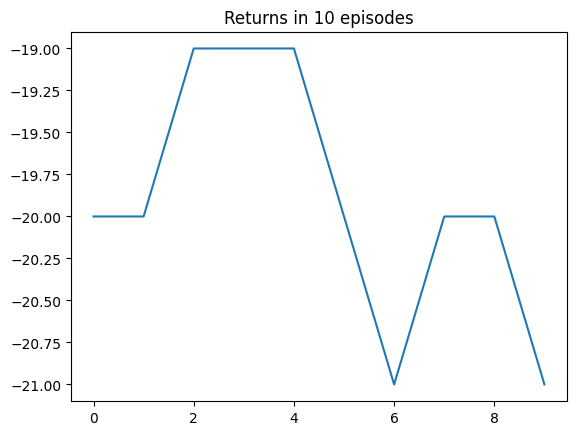

In [6]:
env = gym.make("ALE/Pong-v5", render_mode="rgb_array")
env = wrappers.RecordVideo(env, "./gym-results")
env.reset(seed=42)

# hyperparams
num_steps = 10000
ep_returns = []
ep_return = 0
num_eps = 0
for _ in trange(num_steps):
   action = env.action_space.sample() 
   observation, reward, done, info = env.step(action)

   ep_return += reward

   if done:
      observation = env.reset()
      num_eps += 1
      ep_returns.append(ep_return)
      ep_return = 0
   
env.close()

plt.plot(ep_returns)
plt.title(f"Returns in {num_eps} episodes")

In [3]:
import collections

class FireResetEnv(gym.Wrapper):
    def __init__(self, env=None):
       super(FireResetEnv, self).__init__(env)
       assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
       assert len(env.unwrapped.get_action_meanings()) >= 3

    def step(self, action):
       return self.env.step(action)
       
    def reset(self):
       self.env.reset()
       obs, _, done, _ = self.env.step(1)
       if done:
          self.env.reset()
       obs, _, done, _ = self.env.step(2)
       if done:
          self.env.reset()
       return obs

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        super(MaxAndSkipEnv, self).__init__(env)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip
    
    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
           obs, reward, done, info = self.env.step(action)
           self._obs_buffer.append(obs)
           total_reward += reward
           if done:
               break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info
        
    def reset(self):
       self._obs_buffer.clear()
       obs = self.env.reset()
       self._obs_buffer.append(obs)
       return obs


class ProcessFrame84(gym.ObservationWrapper):
    def __init__(self, env=None):
         super(ProcessFrame84, self).__init__(env)
         self.observation_space = gym.spaces.Box(low=0, high=255, 
                               shape=(84, 84, 1), dtype=np.uint8)
    
    def observation(self, obs):
         return ProcessFrame84.process(obs)
         
         
    @staticmethod
    def process(frame):
        if frame.size == 210 * 160 * 3:
             img = np.reshape(frame, [210, 160,  3]).astype(np.float32)
        elif frame.size == 250 * 160 * 3:
             img = np.reshape(frame, [250, 160, 3]).astype(np.float32)
        else:
             assert False, "Unknown resolution."       

        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110),            
                        interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)


class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, 
                 axis=0),old_space.high.repeat(n_steps, axis=0),     
                 dtype=dtype)
    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low,
        dtype=self.dtype)
        return self.observation(self.env.reset())
    
    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer

class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0,            
                                shape=(old_shape[-1], 
                                old_shape[0], old_shape[1]),
                                dtype=np.float32)
    def observation(self, observation):
      return np.moveaxis(observation, 2, 0)

class ScaledFloatFrame(gym.ObservationWrapper):
     def observation(self, obs):
         return np.array(obs).astype(np.float32) / 255.0

def make_env(env_id):
    env = gym.make(env_id)
    env = MaxAndSkipEnv(env)
    env = FireResetEnv(env)
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env) 
    env = BufferWrapper(env, 4)
    return ScaledFloatFrame(env)


# Atari envs are not up to the new gym API
def train_atari_model(env, Q: ConvQNet, hparams):
    # Pseudocode from DQN Paper
    device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
    writer = SummaryWriter("pong")

    # Hyperparams
    batch_size = hparams["batch_size"]
    update_freq = hparams["update_freq"]
    gamma = hparams["gamma"]
    buffer_size = hparams["buffer_size"]
    lr = hparams["learning_rate"]
    training_steps = hparams["training_steps"]


    # Intialize optimizer
    optimizer = pt.optim.Adam(Q.parameters(), lr=lr)

    # Initialize Replay Memory to capacity N
    memory = ReplayMemory(buffer_size, env)

    # Initialize action-value Function Q with random weights
    T = deepcopy(Q)

    obs = env.reset()
    ep_return = 0
    ep_length = 0
    for global_step in tqdm(range(training_steps)):

        # Select action random action with prob epsilon, otherwise argmax_a Q(obs, a)
        epsilon = linear_schedule(1.0, 0.05, 0.1 * training_steps ,global_step)
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            q_vals = Q(pt.Tensor(obs).unsqueeze(0))
            action = pt.argmax(q_vals).cpu().numpy()

        obs_n, r, done, info = env.step(action)

        # Record statistics seems to be broken for some envs
        ep_return += r
        ep_length += 1

        if "episode" in info.keys():
            writer.add_scalar("charts/episodic_return", ep_return, global_step)
            writer.add_scalar("charts/episodic_length", ep_length, global_step)
            writer.add_scalar("charts/epsilon", epsilon, global_step)

        memory.store_transition(obs, action, obs_n, r, done)

        # handle terminal observations
        obs = obs_n
        if done:
            obs = env.reset()
            ep_return = 0
            ep_length = 0

        if (memory.counter > memory.size and global_step % hparams["train_freq"] == 0):

            # Update network weights on batch
            states, actions, states_, rewards, dones = memory.sample_batch(batch_size)

            # Target values
            with pt.no_grad():
                q_next, _ = T.forward(states_).max(dim=1)
                q_next = q_next.reshape(-1, 1)
                q_target = rewards + gamma*(1-dones)*q_next

            # Predicted values
            q_pred = Q.forward(states)
            q_pred = pt.gather(q_pred, dim=1, index=actions)

            loss = F.smooth_l1_loss(q_pred, q_target)
        
            # Optimize
            optimizer.zero_grad()
            loss.backward()

            # Stable baselines:  https://github.com/DLR-RM/stable-baselines3/blob/4fb8aec215fd2dd5d668aae8285937c268baca97/stable_baselines3/dqn/dqn.py#L216
            # nn.utils.clip_grad_norm_(Q.parameters(), 10)             

            optimizer.step()

            if global_step % 200 == 0:
                grads = [pt.flatten(params.grad.detach()) for params in Q.parameters()]
                grads = pt.cat(grads).view(-1,1)
                writer.add_histogram("charts/action_dist", actions, global_step)
                writer.add_scalar("losses/grads", np.linalg.norm(grads.numpy()), global_step)
                writer.add_scalar("losses/td_loss", loss.detach().numpy(), global_step)
                writer.add_scalar("losses/value_fn", q_pred.mean().item(), global_step)
                writer.add_scalar("losses/q_vals [max]", q_pred.max().item(), global_step)

            if global_step % update_freq == 0:
                T.load_state_dict(Q.state_dict())
    
    env.close()
    writer.close()
    return Q
    
def generate_video(net, env, steps):

    obs, _ = env.reset()
    for i in range(steps):
        q_vals = net(pt.Tensor(obs))
        action = pt.argmax(q_vals).cpu().numpy()

        obs, _, done, _ = env.step(action)

        if done:
            break
    
    env.close()
    return

In [4]:
env = make_env("ALE/Pong-v5")
env = gym.wrappers.RecordEpisodeStatistics(env)
q = ConvQNet(env)

params = DEFAULT_HPARAMS
params["buffer_size"] = 50_000
params["traning_steps"] = 1_000_000
q = train_atari_model(env, q, params)

env = make_env("ALE/Pong-v5")
env = gym.wrappers.RecordVideo(env, "./atari")
generate_video(q, env, 2000)

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
  0%|          | 148/250000 [00:00<11:21, 366.36it/s]

: 

: 

cuda
